In [86]:
import csv
import json
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as ply
import matplotlib.pyplot as plt
import numpy as np
from plotly import tools
from IPython.display import display
ply.init_notebook_mode(connected=True)
%matplotlib inline

In [64]:
exchs = ['bitfinex', 'bitstamp', 'cex', 'exmo', 'gdax', 'kraken', 'livecoin']
n_exch = len(exchs)

In [77]:
def read_data(pair):
    curs = pair.split('_')
    print('Base currency:', curs[0])
    print('Quote currency:', curs[1])
    print('N.B. Please note that profit is given in quote currency')

    df = pd.read_csv(pair + '_arb.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    print('\nNumber of entries:', df.shape[0])

    display(df.head())
    display(df.tail())
    
    return df

In [71]:
def count_entries(df):
    buy_exch_cnt = {exch: 0 for exch in exchs}
    sell_exch_cnt = {exch: 0 for exch in exchs}
    pair_exch_cnt = {exch1: {exch2: 0 for exch2 in exchs} for exch1 in exchs}

    for ix in df.index:
        buy_exch = df.loc[ix, 'buy_exchange']
        sell_exch = df.loc[ix, 'sell_exchange']
        buy_exch_cnt[buy_exch] += 1
        sell_exch_cnt[sell_exch] += 1  
        pair_exch_cnt[buy_exch][sell_exch] += 1
    
    print('\nExchanges where we buy')
    display(buy_exch_cnt)
    
    print('\nExchanges where we sell')
    display(sell_exch_cnt)
    
    pairs_df = pd.DataFrame.from_dict(pair_exch_cnt, orient='index')
    print('\n\nPairs of exchanges (row ~ buy, col ~ sell)')
    display(pairs_df)
    
    return pairs_df

In [72]:
def get_data_dict(df):
    data_dict = dict()
    for exch1 in exchs:
        for exch2 in exchs:
            data_dict[(exch1, exch2)] = {'profit': [], 'volume_quote': [], 'volume_base': []}
    for ix in df.index:
        buy_exch = df.loc[ix, 'buy_exchange']
        sell_exch = df.loc[ix, 'sell_exchange']
        data_dict[(buy_exch, sell_exch)]['profit'].append(df.loc[ix, 'profit'])
        data_dict[(buy_exch, sell_exch)]['volume_quote'].append(df.loc[ix, 'volume_quote'])
        data_dict[(buy_exch, sell_exch)]['volume_base'].append(df.loc[ix, 'volume_base'])
    return data_dict

In [91]:
def plot_my_data(data_dict, pairs_df, col, lib='plotly'):
    if lib == 'plotly':
        for pair in data_dict:
            exch1 = pair[0]
            exch2 = pair[1]
            if exch1 != exch2 and pairs_df.loc[exch1, exch2] > 0:
                data = [go.Histogram(x = data_dict[(exch1, exch2)][col])]
                layout = go.Layout(
                    title='Buying on {}, selling on {} ({})'.format(exch1, exch2, pairs_df.loc[exch1, exch2]),
                    xaxis=dict(
                        title=col
                    ),
                    yaxis=dict(
                        title='Count'
                    ),
                )
                fig = go.Figure(data=data, layout=layout)
                ply.iplot(fig)
    elif lib == 'matplotlib':
        for pair in data_dict:
            exch1 = pair[0]
            exch2 = pair[1]
            if exch1 != exch2 and pairs_df.loc[exch1, exch2] > 0:
                plt.hist(data_dict[(exch1, exch2)][col], bins=25)
                plt.title(exch1 + '_' + exch2 + ' ({})'.format(pairs_df.loc[exch1, exch2]))
                plt.show()

In [100]:
def plot_my_data_square(data_dict, pairs_df, col, lib='plotly'):
    fig, ax = plt.subplots(n_exch, n_exch, figsize=(50,50))
    fig.suptitle('Profit (USD)')
    for i in range(n_exch):
        exch1 = exchs[i]
        for j in range(n_exch):
            exch2 = exchs[j]
            if exch1 != exch2 and pairs_df.loc[exch1, exch2] > 0:
                ax[i,j].hist(data_dict[(exch1, exch2)][col], bins=25)
                ax[i,j].set_title(exch1 + '_' + exch2 + ' ({})'.format(pairs_df.loc[exch1, exch2]))
#             else:
#                 ax[i,j].axis('off')
    fig.subplots_adjust(hspace=0.5)
    #plt.tight_layout()
    plt.show()    

In [101]:
def get_and_process_data(pair):
    df = read_data(pair)
    pairs_df = count_entries(df)
    data_dict = get_data_dict(df)
    return data_dict

pair = 'btc_usd'
data_dict = get_and_process_data(pair)

Base currency: btc
Quote currency: usd
N.B. Please note that profit is given in quote currency

Number of entries: 25916


,timestamp,buy_exchange,sell_exchange,profit,volume_quote,volume_base
0,2018-07-02 12:13:36.821283,bitfinex,livecoin,235.963228,10020.0,1.579198
1,2018-07-02 12:13:36.821283,bitstamp,livecoin,230.293142,10025.0,1.579095
2,2018-07-02 12:13:36.821283,cex,livecoin,202.384398,10025.0,1.574797
3,2018-07-02 12:13:36.821283,exmo,livecoin,211.997161,10020.0,1.575508
4,2018-07-02 12:13:36.821283,gdax,livecoin,238.540883,10030.0,1.581135


,timestamp,buy_exchange,sell_exchange,profit,volume_quote,volume_base
25911,2018-07-04 08:05:55.105519,bitstamp,livecoin,51.556331,10025.000000,1.540808
25912,2018-07-04 08:05:55.105519,cex,livecoin,59.782002,10025.000000,1.542068
25913,2018-07-04 08:05:55.105519,exmo,livecoin,26.200634,3297.407717,0.506401
25914,2018-07-04 08:05:55.105519,gdax,livecoin,46.898535,10030.000000,1.540860
25915,2018-07-04 08:05:55.105519,kraken,livecoin,50.480313,10026.000000,1.540796



Exchanges where we buy


{'bitfinex': 3452,
 'bitstamp': 3513,
 'cex': 3412,
 'exmo': 8637,
 'gdax': 3438,
 'kraken': 3464,
 'livecoin': 0}


Exchanges where we sell


{'bitfinex': 1806,
 'bitstamp': 636,
 'cex': 1359,
 'exmo': 104,
 'gdax': 814,
 'kraken': 1043,
 'livecoin': 20154}



Pairs of exchanges (row ~ buy, col ~ sell)


,bitfinex,bitstamp,cex,exmo,gdax,kraken,livecoin
bitfinex,0,0,38,38,0,0,3376
bitstamp,2,0,92,23,0,0,3396
cex,7,2,0,0,3,2,3398
exmo,1797,634,1153,0,811,1041,3201
gdax,0,0,47,1,0,0,3390
kraken,0,0,29,42,0,0,3393
livecoin,0,0,0,0,0,0,0


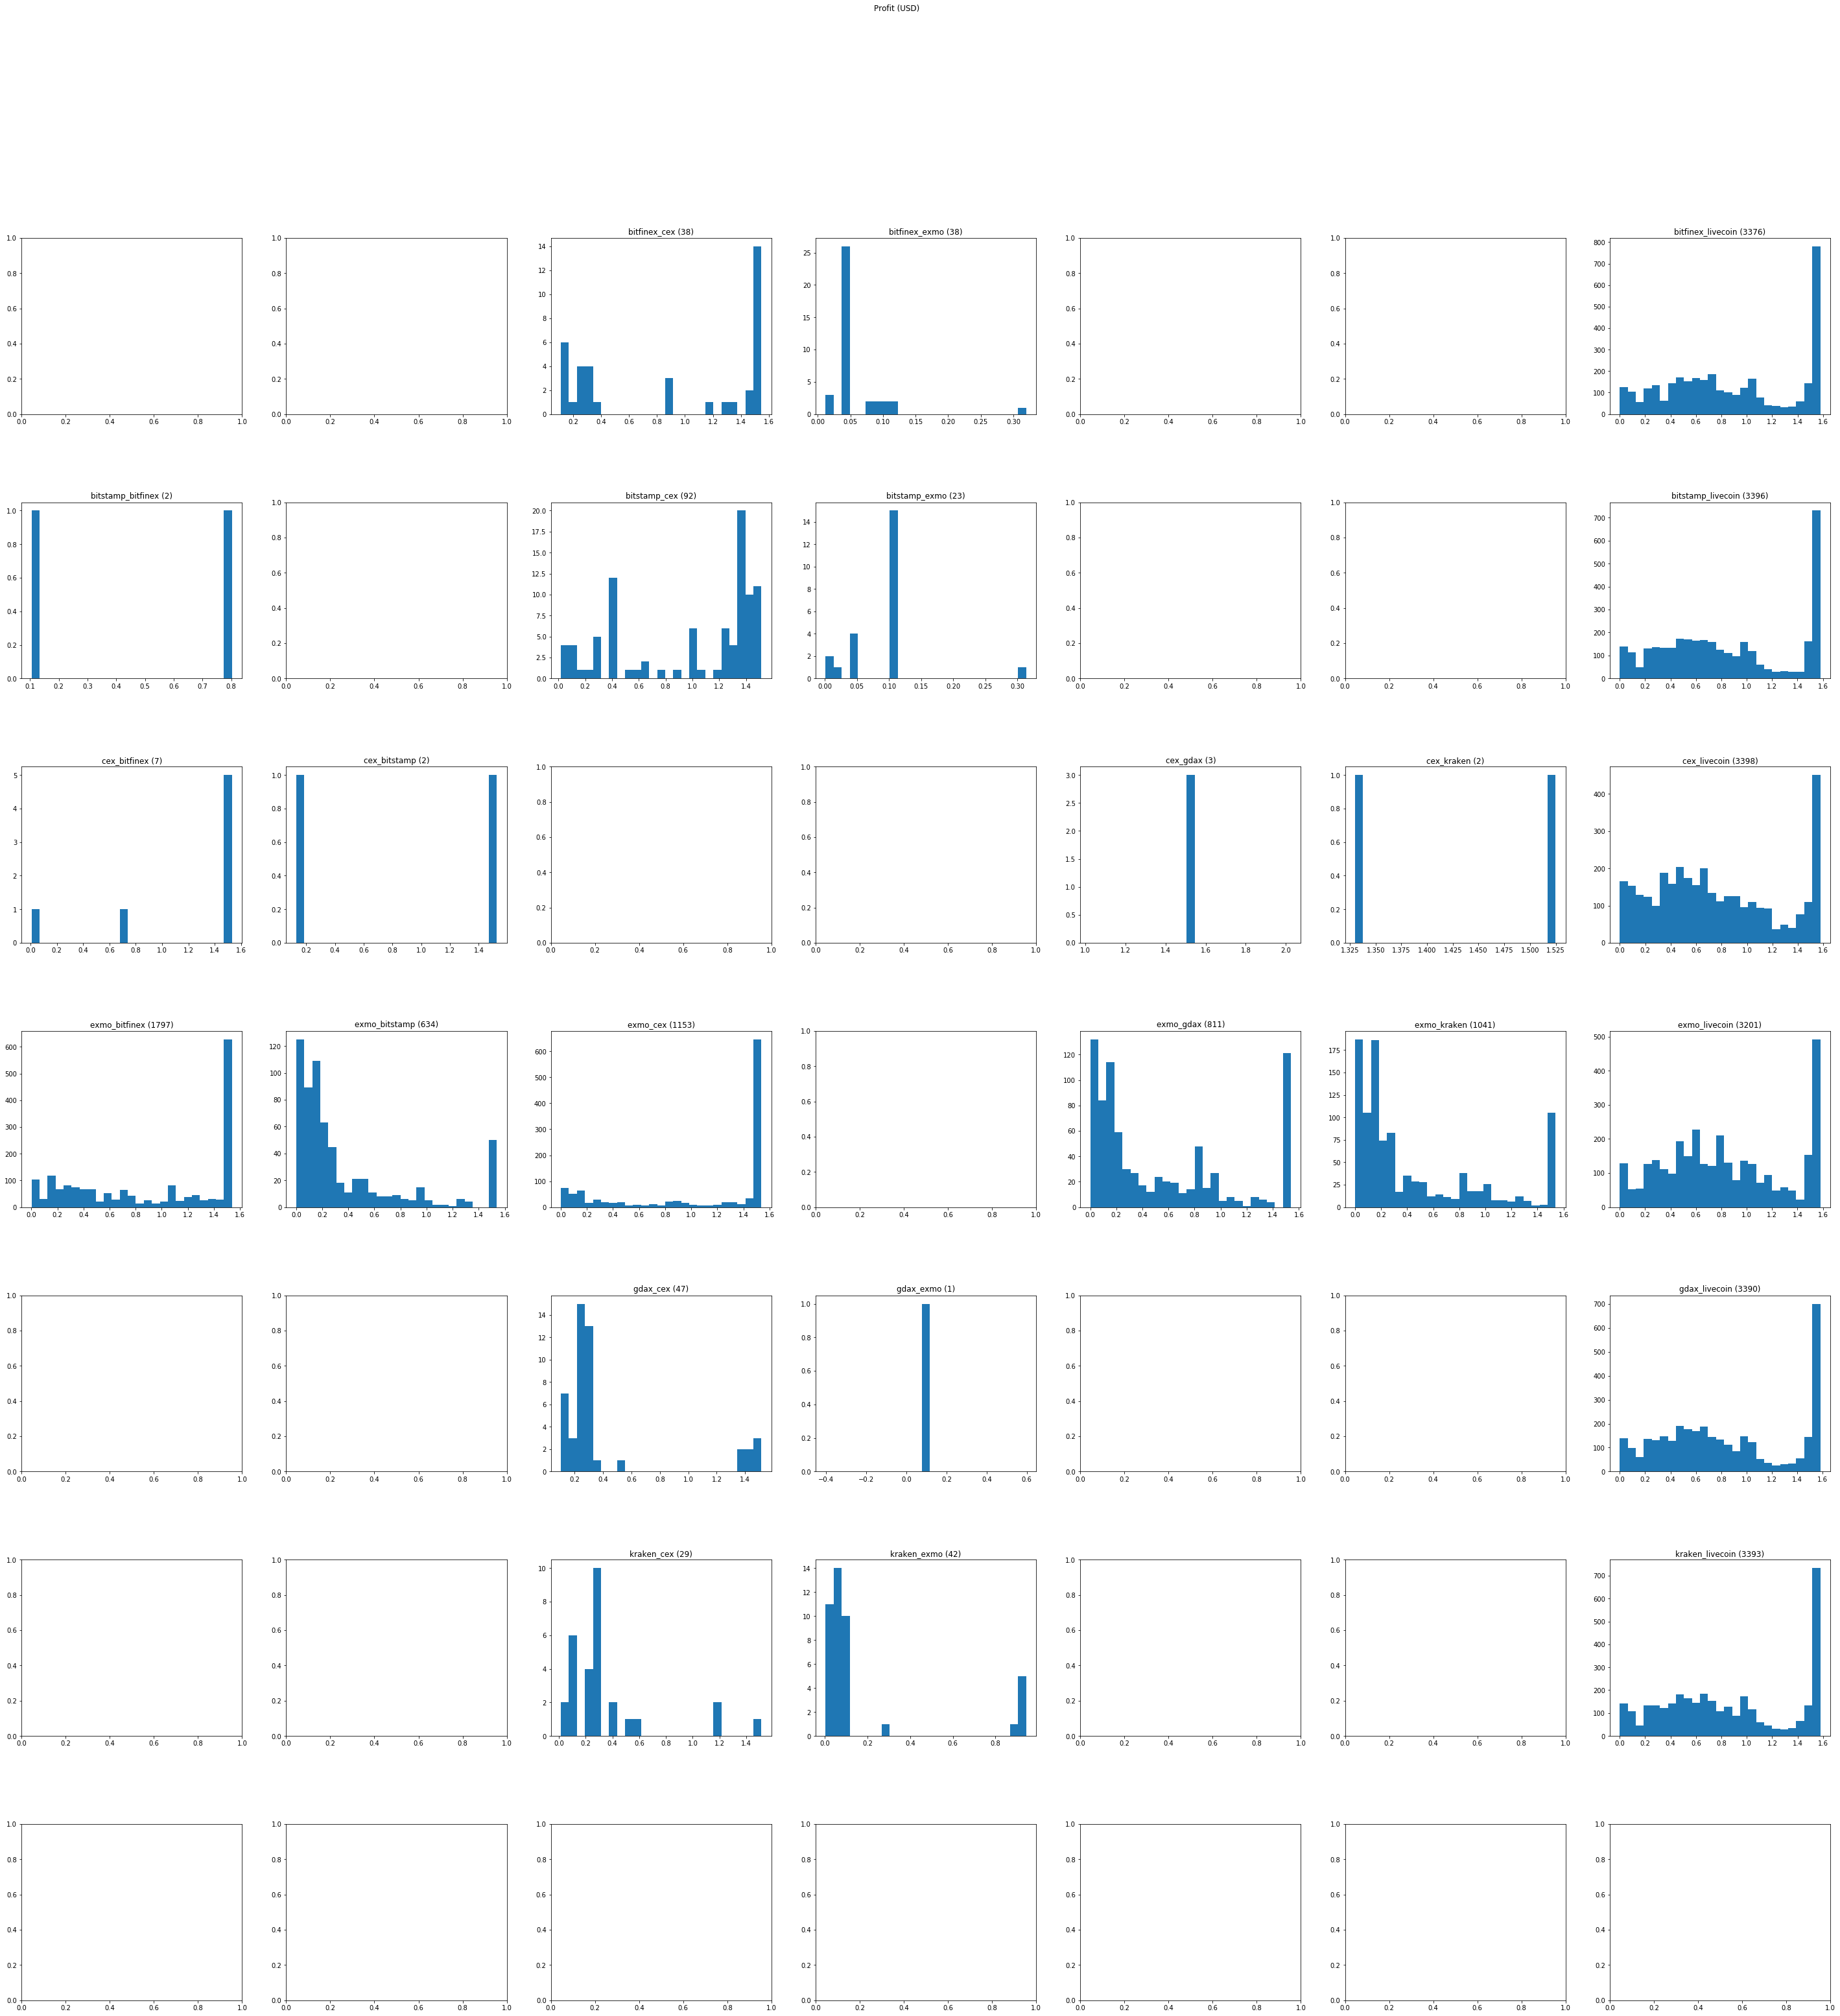

In [104]:
col = 'volume_base'  # Must be one of 'profit', 'volume_quote' and 'volume_base'
plot_my_data_square(data_dict, pairs_df, col)
plot_my_data(data_dict, col)

In [87]:


# def plot_my_data_with_plotly(data_dict, col):
#     subplot_titles = []
#     for pair in data_dict:
#         exch1 = pair[0]
#         exch2 = pair[1]
#         subplot_titles.append(title='Buying on {}, selling on {} ({})'.format(exch1, exch2, pairs_df.loc[exch1, exch2]))
        
#     fig = tools.make_subplots(rows=n_exch, cols=n_exch, subplot_titles=('Plot 1', 'Plot 2', 'Plot 3', 'Plot 4'))
#     for pair in data_dict:
#         exch1 = pair[0]
#         exch2 = pair[1]
#         if exch1 != exch2 and pairs_df.loc[exch1, exch2] > 0:
#             trace = go.Histogram(x = data_dict[(exch1, exch2)][col])
#             layout = go.Layout(
#                 xaxis=dict(
#                     title=col
#                 ),
#                 yaxis=dict(
#                     title='Count'
#                 ),
#             )
#             fig = go.Figure(data=data, layout=layout)
#             ply.iplot(fig)


# # trace1 = go.Scatter(x=[1, 2, 3], y=[4, 5, 6])
# # trace2 = go.Scatter(x=[20, 30, 40], y=[50, 60, 70])
# # trace3 = go.Scatter(x=[300, 400, 500], y=[600, 700, 800])
# # trace4 = go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000])



# # fig.append_trace(trace1, 1, 1)
# # fig.append_trace(trace2, 1, 2)
# # fig.append_trace(trace3, 2, 1)
# # fig.append_trace(trace4, 2, 2)

# # fig['layout'].update(height=600, width=600, title='Multiple Subplots' +
# #                                                   ' with Titles')

# # py.iplot(fig, filename='make-subplots-multiple-with-titles')